This notebook originally made by Matt Nicholl.<br>
Interesting transients are selected from the ZTF stream, then these are looked up in various ways:<br> 
    __[The Transient Name Server](https://wis-tns.weizmann.ac.il/)__ <br>
    __[PanSTARRS-1 Image Access](http://ps1images.stsci.edu/cgi-bin/ps1cutouts)__<br>
    __[Open Astronomy Catalogs](https://astrocats.space/)__<br>
    At the end, you see the chosen candidates with light curves from ZTF and OAC, as well as the PanStarrs cutouts.

In [1]:
import mysql.connector
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from collections import OrderedDict
import matplotlib.image as mpimg
import os
import csv
import io as StringIO

In [2]:
# connect to database. You should already have the settings.py file.
import settings
msl = mysql.connector.connect(\
            user    =settings.DB_USER, \
            password=settings.DB_PASS, \
            host    =settings.DB_HOST, \
            database='ztf')

In [3]:
import time, datetime
now = datetime.datetime.now()
print ("This notebook was run on " + now.isoformat())

jdnow = time.time()/86400 + 2440587.5
print ("and the Julian Date is {}".format(jdnow))

This notebook was run on 2019-06-17T09:02:34.898600
and the Julian Date is 2458651.835126143


In [4]:
# select good candidates
# can add further criteria...

# From the last 3 months
start_date = '%.1f' % (jdnow - 90)

# Default quality cuts
quality = 'rb >= 0.75 and nbad = 0 and fwhm <= 5 and elong <= 1.2 and abs(magdiff) <= 0.1 '

# Further cuts on individual detections
cand_of_interest = 'sgscore1 < 0.4 and jdstarthist > ' + start_date

# Cuts on object metadata
obj_of_interest = 'ncand >= 5 '

cursor = msl.cursor(buffered=True, dictionary=True)

# First query candidate database...
query_cand = 'SELECT *,candid,objectId from candidates WHERE '
query_cand += quality
query_cand += 'and '
query_cand += cand_of_interest
# ... making sure associated objects also pass cuts
query_cand += 'and objectId in (SELECT objectId from objects WHERE '
query_cand += obj_of_interest
query_cand += ')'

print ("Candidate query is:\n" + query_cand)

results = cursor.execute(query_cand)
n = cursor.rowcount
print ('\nfound %d good candidates' % n)
candidates = cursor.fetchall()

Candidate query is:
SELECT *,candid,objectId from candidates WHERE rb >= 0.75 and nbad = 0 and fwhm <= 5 and elong <= 1.2 and abs(magdiff) <= 0.1 and sgscore1 < 0.4 and jdstarthist > 2458561.8and objectId in (SELECT objectId from objects WHERE ncand >= 5 )

found 3533 good candidates


In [5]:
# Then query objects...
query_obj = 'SELECT * FROM objects WHERE '
query_obj += obj_of_interest
# ... making sure the candidates are the same set as above
query_obj += 'and objectId in (SELECT objectId from candidates WHERE '
query_obj += quality
query_obj += 'and '
query_obj += cand_of_interest
query_obj += ')'

print ("Object query is:\n" + query_cand)

results = cursor.execute(query_obj)
n = cursor.rowcount
print ('\nfound %d objects' % n)
objects = cursor.fetchall()

cursor.close()

Object query is:
SELECT *,candid,objectId from candidates WHERE rb >= 0.75 and nbad = 0 and fwhm <= 5 and elong <= 1.2 and abs(magdiff) <= 0.1 and sgscore1 < 0.4 and jdstarthist > 2458561.8and objectId in (SELECT objectId from objects WHERE ncand >= 5 )

found 1091 objects


True

In [6]:
# Make dictionary of objects with light curves and metadata

# needed for light curve
lc_keys = ['jd', 'magpsf', 'sigmapsf', 'fid']

# attibutes of the nearest PS1 object
host_keys = ['distpsnr1', 'sgscore1', 'sgmag1', 'srmag1'] 

objectdict = {}

for row in objects:
    objectdict[row['objectId']] = row
    objectdict[row['objectId']]['lc'] = []
    
for j in candidates:
    lightcurvedict = dict((l, j[l]) for l in lc_keys if l in j)
    objectdict[j['objectId']]['lc'].append(lightcurvedict)
    if 'host' not in objectdict[j['objectId']]:
        hostdict = dict((k, j[k]) for k in host_keys if k in j)
        objectdict[j['objectId']]['host'] = hostdict

In [7]:
# Apply further filters here

# If no filtering desired, simply set:
#objectdict = objectdict

# For this example, using objects with at least 10 detections
minpoints = 6

targetlist = []

for l in objectdict:
    if len(objectdict[l]['lc']) >= minpoints:
        targetlist.append(l)
        
print('found %d events with >=%d detections' % (len(targetlist),minpoints))

found 163 events with >=6 detections


## Query the Transient Name Server

In [8]:
# Query TNS for classifications

tns_url = "https://wis-tns.weizmann.ac.il/api/get/"
api_key="9a8a461eb820b886d28d412290223ad6dc971ebc"

print('Searching TNS...')
print ("\nZTF objectId    TNS id    Type     Sherlock")
for i in targetlist:

    # start with cone search around ZTF coordinates
    search_obj = OrderedDict([
        ("ra",objectdict[i]['ramean']), 
        ("dec",objectdict[i]['decmean']), 
        ("radius","2.5"), 
        ("units","arcsec"), 
        ("objname",""), 
        ("internal_name","")]) 
    search_url = tns_url+'search'
    search_data = [('api_key',(None, api_key)), ('data',(None,json.dumps(search_obj)))]

    r = requests.post(search_url, files=search_data)

    # If transient is known, will have an IAU name (AT/SN 20XXyy), add such names to our objects
    if r.json()['data']['reply']:
        iau_name = r.json()['data']['reply'][0]['objname']
        objectdict[i]['iau_name'] = r.json()['data']['reply'][0]['prefix'] + iau_name


        # Now check if object has a classification attached
        # Always will for 'SN' names, but could also happen for 'AT', e.g. if TDE rather than SN
        get_obj = OrderedDict([("objname",iau_name), ("photometry","0"), ("spectra","0")])
        get_url = tns_url+'object'
        get_data = [('api_key',(None, api_key)), ('data',(None,json.dumps(get_obj)))]
  
        r2 = requests.post(get_url, files=get_data)
     
        # If classified, add type to dictionary
        if r2.json()['data']['reply']['object_type']['name']:
            objectdict[i]['class'] = r2.json()['data']['reply']['object_type']['name']
            t = objectdict[i]['class']
        else:
            t = '     '


        print ("%s   %s   %s      %s" % (i, objectdict[i]['iau_name'], t,objectdict[i]['sherlock_classification']))

print('\nDone.')

Searching TNS...

ZTF objectId    TNS id    Type     Sherlock
ZTF19aasekcx   SN2019ejp   SN IIn      SN
ZTF19aaraxhh   SN2019duf   SN Ia      NT
ZTF19aanesxt   SN2019cmh   SN Ia      SN
ZTF19aatgrxv   SN2019ens   SN Ia      NT
ZTF19aarioci   AT2019ehz              NT
ZTF19aanhlzn   SN2019cet   SN Ia      SN
ZTF19aarfkch   AT2019dwf              ORPHAN
ZTF19aasensj   AT2019ejr              NT
ZTF19aavjzny   AT2019gbp              SN
ZTF19aauitks   SN2019fcm   SN Ia      NT
ZTF19aauvblr   AT2019fza              SN
ZTF19aavhblr   SN2019fuo   SN II      NT
ZTF19aavipfj   AT2019gyv              SN
ZTF19aatvmbo   SN2019enp   SN Ia-91T-like      SN
ZTF19aavmlqh   SN2019gbq   SN Ia      NT
ZTF19aavlgdy   AT2019fyh              NT
ZTF19aavrswr   SN2019gcw   SN Ia      ORPHAN
ZTF19aavpzke   AT2019ghp              NT
ZTF19aavwbpc   AT2019gtl              NT
ZTF19aavqotz   AT2019ged              NT
ZTF19aavhwxs   SN2019gct   SN Ia      NT
ZTF19aawnqoj   SN2019gxg   SN Ia      NT
ZTF19aavowpa   AT2

In [9]:
# Apply more cuts based on TNS data

targetlist2 = []

# e.g. classified transients only, excluding SNe Ia:
for i in targetlist:
    if 'class' in objectdict[i]:
        if objectdict[i]['class'] != 'SN Ia':
            targetlist2.append(i)
        
print('%d events passing final cuts' % len(targetlist2))

30 events passing final cuts


In [10]:
# Get PS1 image of field

ps1_url = 'http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri'

cutout_url = 'http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?&filetypes=stack&size=240'

print('Downloading PS1 cutouts...')

for i in targetlist2:

    dest_file = i + '.jpg'
    objectdict[i]['cutout'] = dest_file

    if not os.path.exists(dest_file):

        # first step searches for the ps1 images matching target coordinates
        ps1_search_url = ps1_url+'&ra='+str(objectdict[i]['ramean'])+'&dec='+str(objectdict[i]['decmean'])
        print(i,objectdict[i]['ramean'],objectdict[i]['decmean'])
        print(ps1_search_url)
        ps1_im = requests.get(ps1_search_url)
        #print("PS1 im.text = ")
        #print(ps1_im.text)
        
        # consistent formatting, hardcoding positions of g,r,i image names within query result
        #ps1_g = ps1_im.text.split(' ')[15]
        #ps1_r = ps1_im.text.split(' ')[31]
        #ps1_i = ps1_im.text.split(' ')[23]
        #print(ps1_g,ps1_r,ps1_i)

        
        # 2019-06-16 KWS Modified this to use a csv and StringIO object and present a dictionary.
        response = csv.DictReader(StringIO.StringIO(ps1_im.text), delimiter=' ', skipinitialspace = True)
        respList = []
        
        for row in response:
            respList.append(row)
            
        ps1_g = respList[0]['filename']
        ps1_r = respList[2]['filename']
        ps1_i = respList[1]['filename']
        #print(ps1_g,ps1_r,ps1_i)

        
        cutout_search_url = cutout_url + '&blue='+ps1_g + '&green='+ps1_r + '&red='+ps1_i
        cutout_search_url +=  '&ra='+str(objectdict[i]['ramean']) + '&dec='+str(objectdict[i]['decmean'])

        cmd = 'wget -O %s "%s"' % (dest_file, cutout_search_url)
        #print(cmd)
        os.system(cmd)
    
print('Done.')

ZTF19aasekcx 212.1191200851852 29.269773607407412
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=212.1191200851852&dec=29.269773607407412
ZTF19aavhblr 232.93076554375 16.71369424375
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=232.93076554375&dec=16.71369424375
ZTF19aatvmbo 320.55933567777777 5.788522255555556
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=320.55933567777777&dec=5.788522255555556
ZTF19aaozsuh 217.05015997045456 -1.6041846795454544
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=217.05015997045456&dec=-1.6041846795454544
ZTF19aawolyt 243.1838834090909 6.11314980909091
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=243.1838834090909&dec=6.11314980909091
ZTF19aavkvpw 179.22925296363636 22.14207082727273
http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?&filters=gri&ra=179.22925296363636&dec=22.14207082727273
ZTF19aauisdr 201.95510837142857 27.72950377142857
http://ps1imag

## Get PanSTARRS image cutouts

## Light curves from Open Astronomy Catalogs

In [11]:
# If known transient, get data from Open Astronomy Catalogs

oac_url = 'https://api.astrocats.space/' # object name goes here
oac_query_string = '/photometry/time+magnitude+e_magnitude+band?time&magnitude'

for i in targetlist2:
    if 'iau_name' in objectdict[i]:
        query_url = oac_url + objectdict[i]['iau_name'] + oac_query_string
        oac_phot = requests.get(query_url)
        d = oac_phot.json()
        objectname = objectdict[i]['iau_name']
        if objectname in d:
            objectdict[i]['oac'] = d[objectname]['photometry']

https://lasair.roe.ac.uk/object/ZTF19aasekcx/


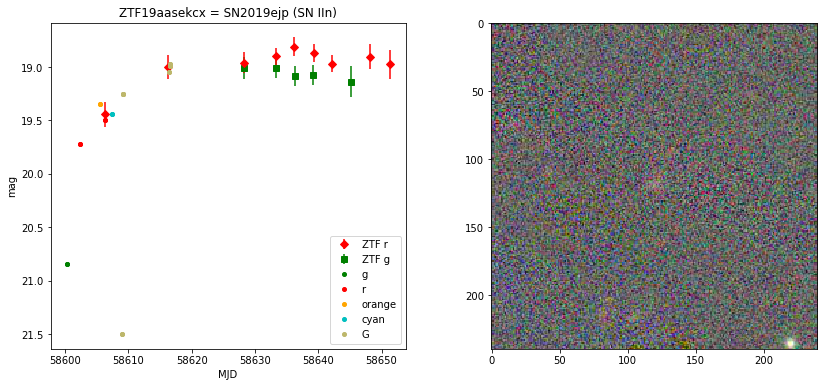

https://lasair.roe.ac.uk/object/ZTF19aavhblr/


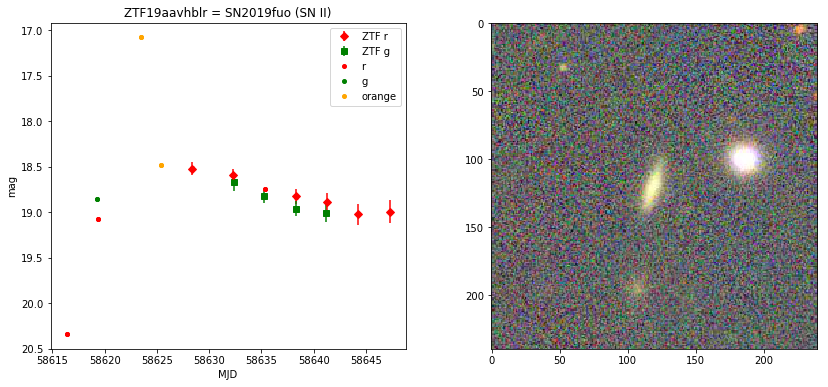

https://lasair.roe.ac.uk/object/ZTF19aatvmbo/


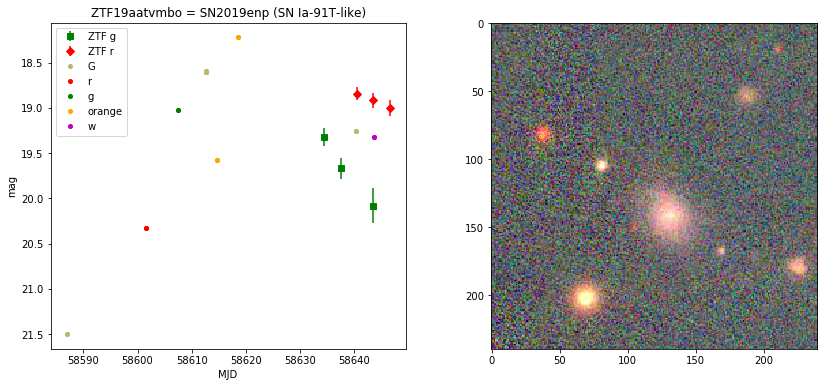

https://lasair.roe.ac.uk/object/ZTF19aaozsuh/


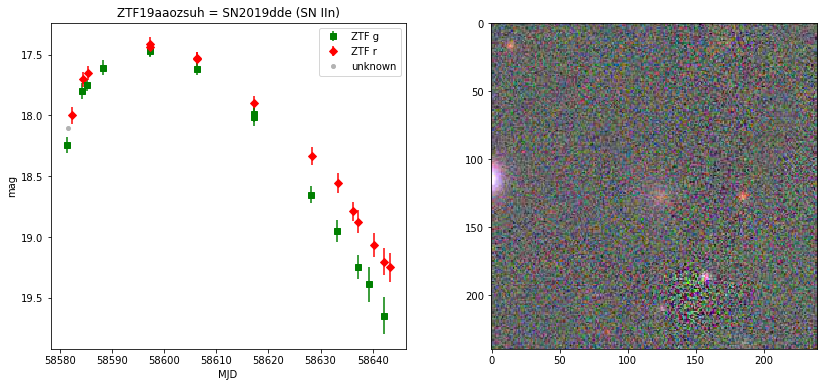

https://lasair.roe.ac.uk/object/ZTF19aawolyt/


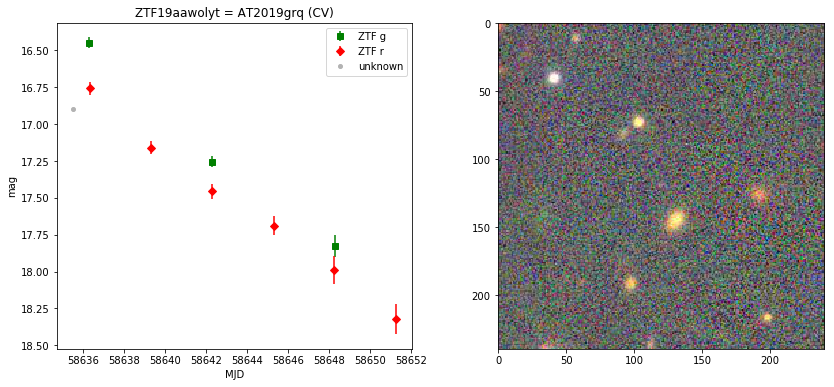

https://lasair.roe.ac.uk/object/ZTF19aavkvpw/


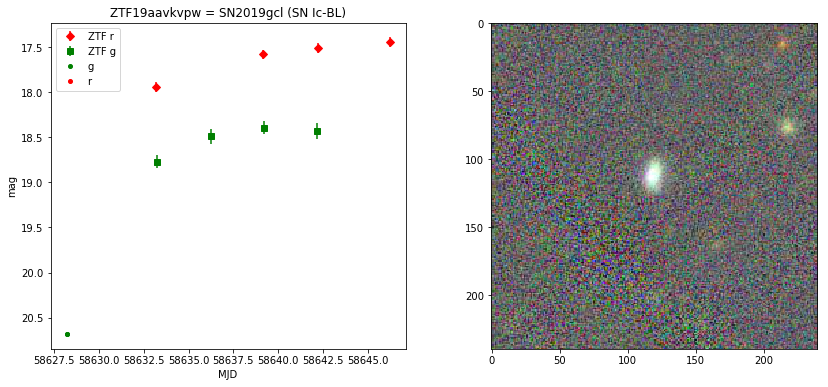

https://lasair.roe.ac.uk/object/ZTF19aauisdr/


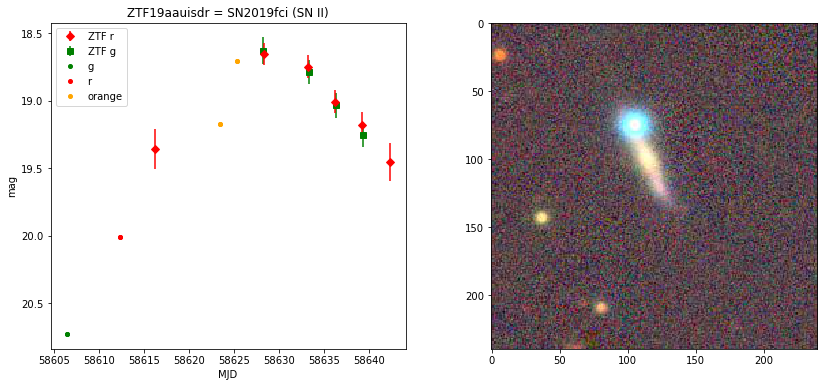

https://lasair.roe.ac.uk/object/ZTF19aavouyw/


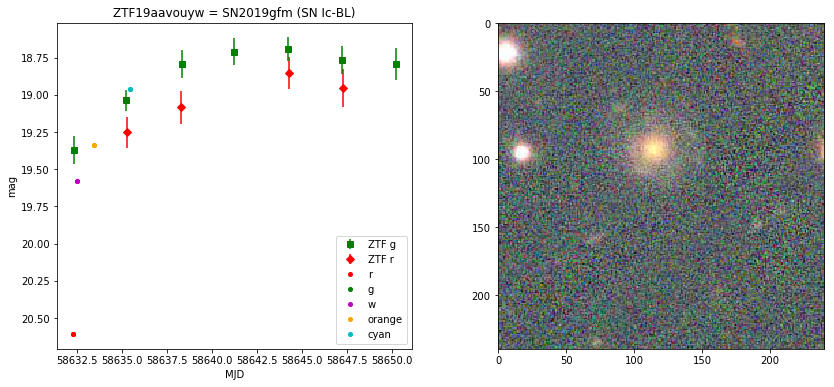

https://lasair.roe.ac.uk/object/ZTF19aaoxvfe/


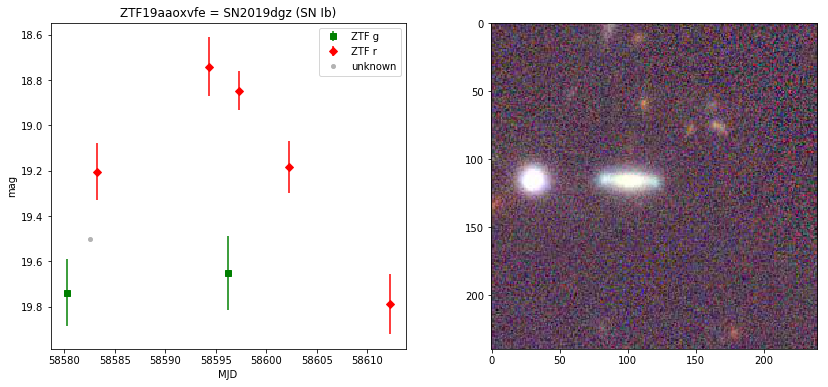

https://lasair.roe.ac.uk/object/ZTF19aaniore/


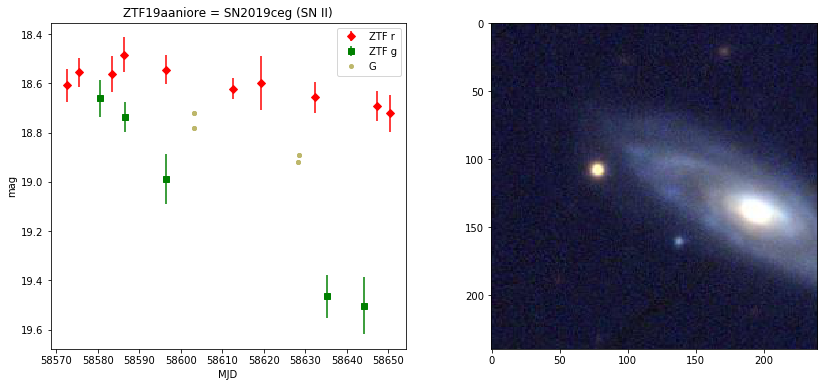

https://lasair.roe.ac.uk/object/ZTF19aapreis/


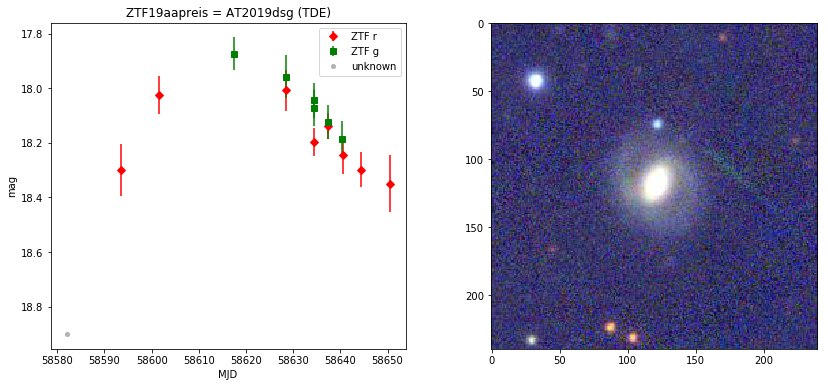

https://lasair.roe.ac.uk/object/ZTF19aanlekq/


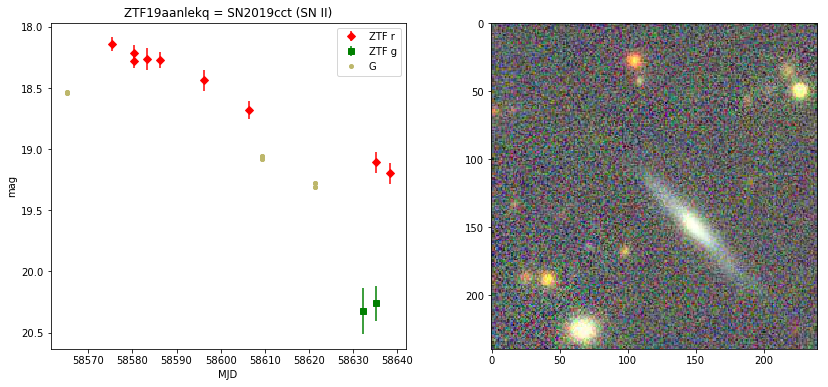

https://lasair.roe.ac.uk/object/ZTF19aaugaam/


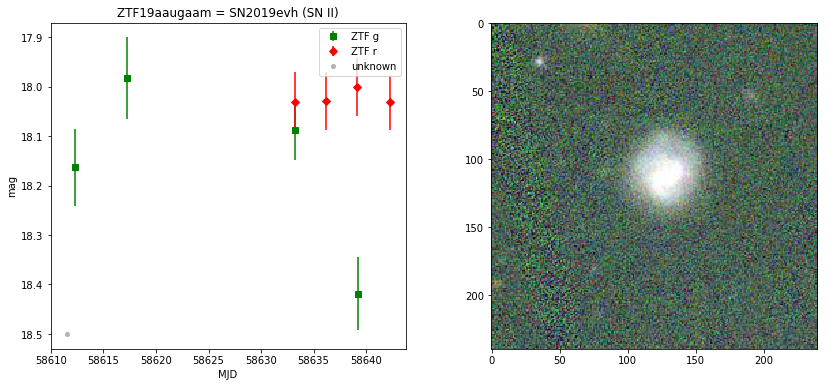

https://lasair.roe.ac.uk/object/ZTF19aaxugwk/


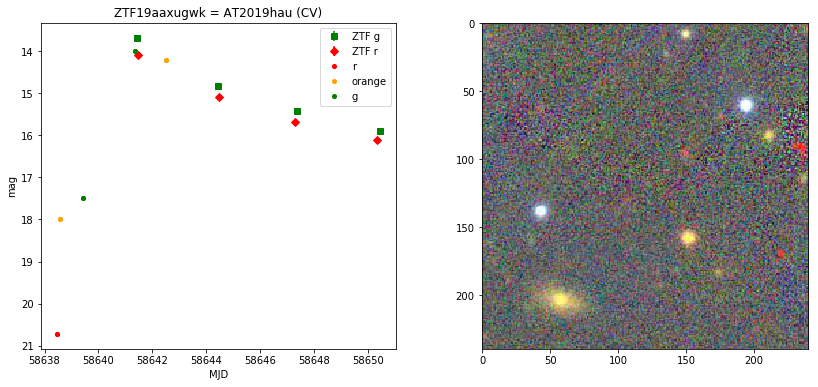

https://lasair.roe.ac.uk/object/ZTF19aauishy/


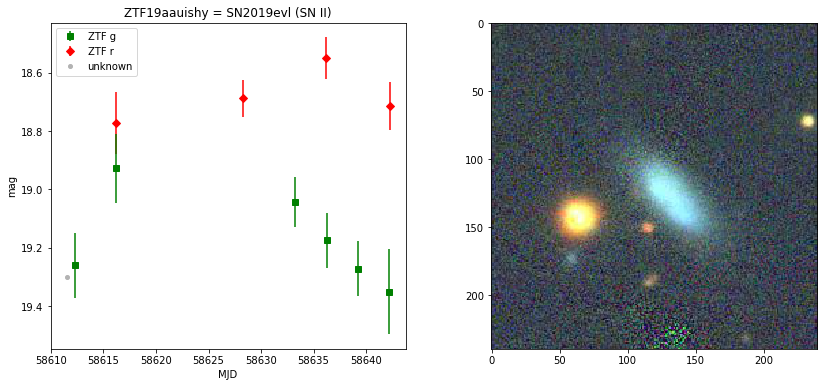

https://lasair.roe.ac.uk/object/ZTF19aavidqf/


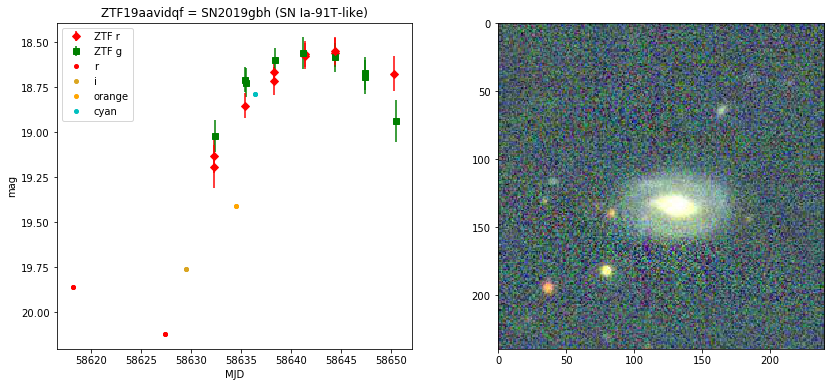

https://lasair.roe.ac.uk/object/ZTF19aaxffum/


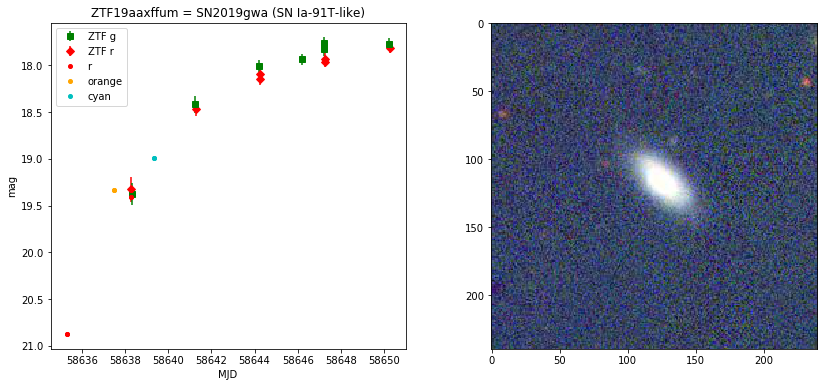

https://lasair.roe.ac.uk/object/ZTF19aavkptg/


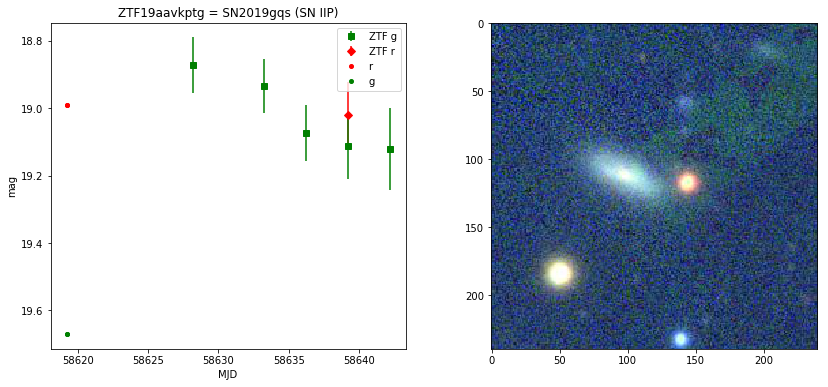

https://lasair.roe.ac.uk/object/ZTF19aathllr/


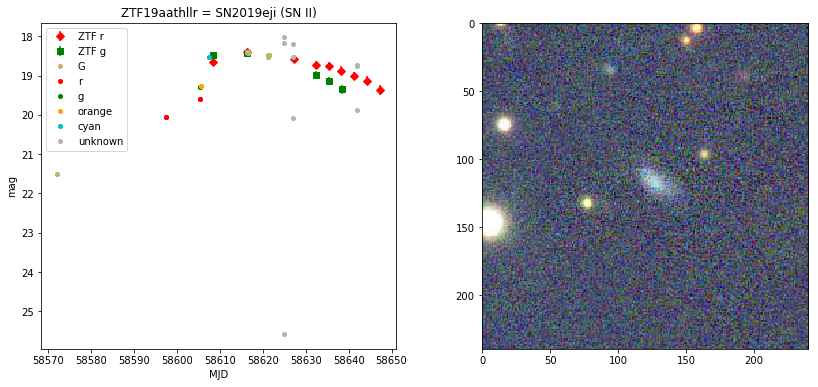

https://lasair.roe.ac.uk/object/ZTF19aauxxgk/


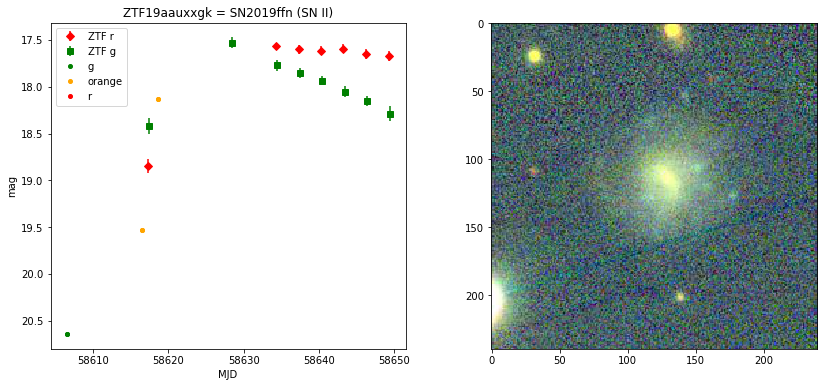

https://lasair.roe.ac.uk/object/ZTF19aaqdkrm/


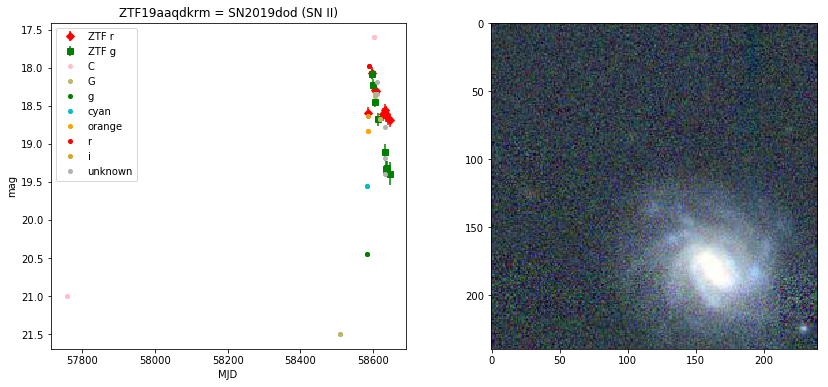

https://lasair.roe.ac.uk/object/ZTF19aavbkly/


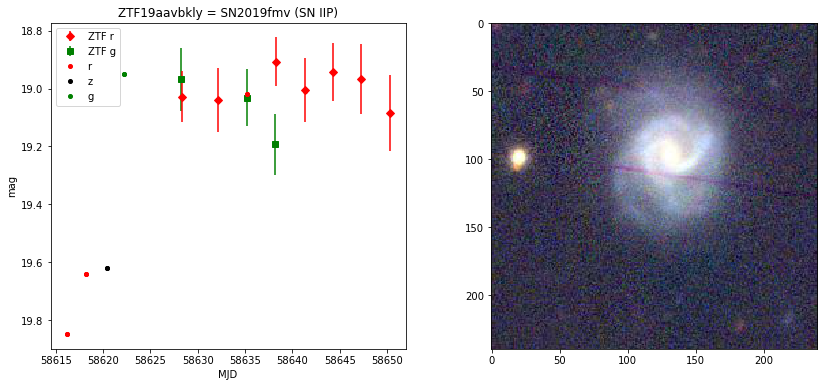

https://lasair.roe.ac.uk/object/ZTF19aavqics/


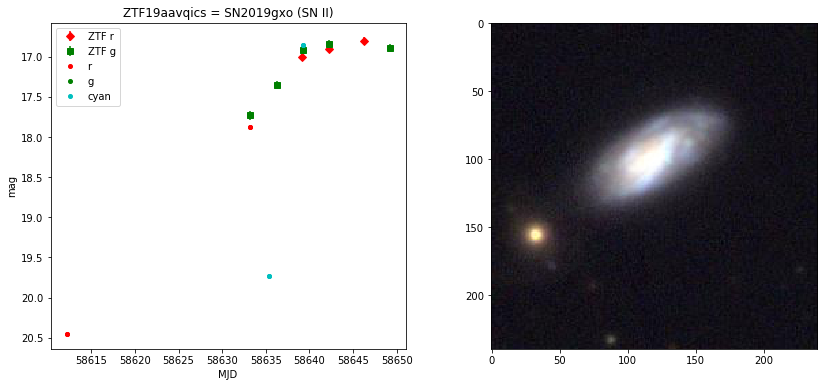

https://lasair.roe.ac.uk/object/ZTF19aatqzim/


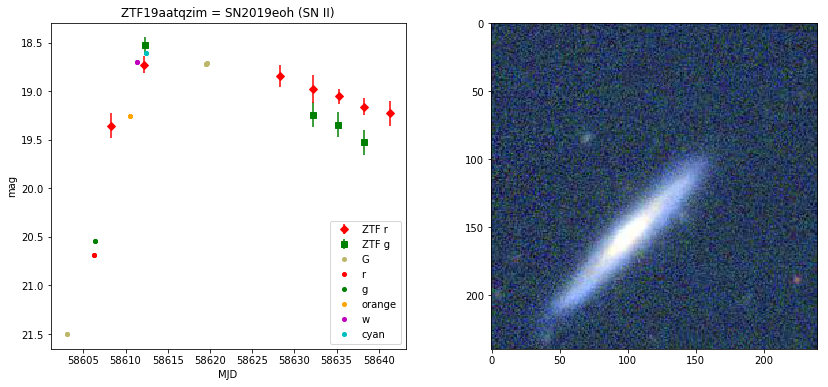

https://lasair.roe.ac.uk/object/ZTF19aauqwna/


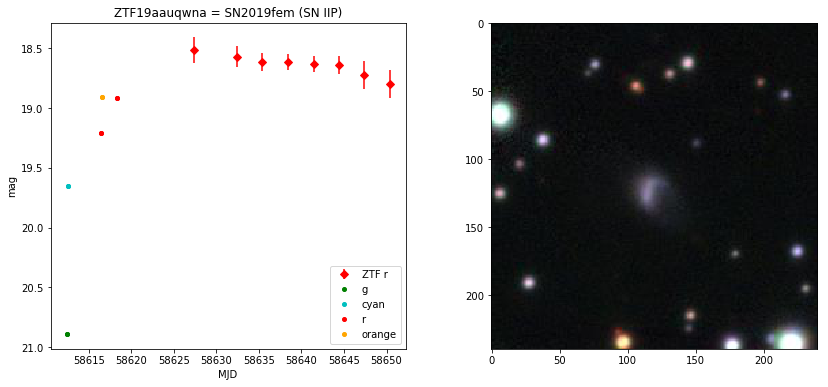

https://lasair.roe.ac.uk/object/ZTF19aapafqd/


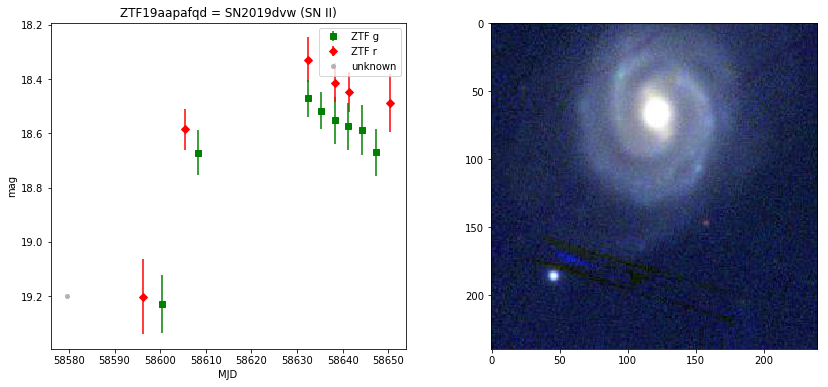

https://lasair.roe.ac.uk/object/ZTF19aarjfqe/


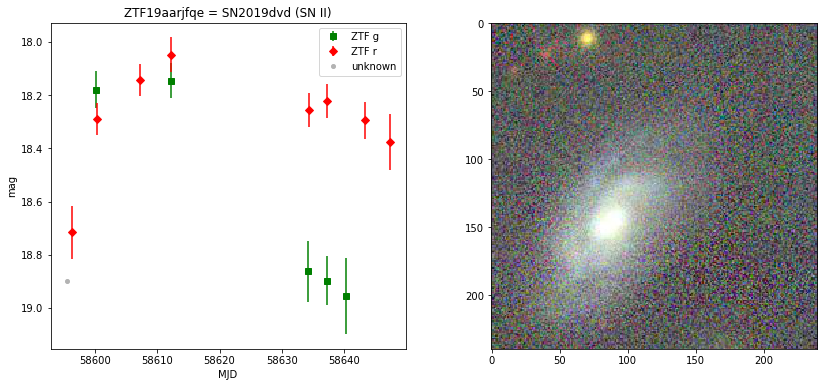

https://lasair.roe.ac.uk/object/ZTF19aawgxdn/


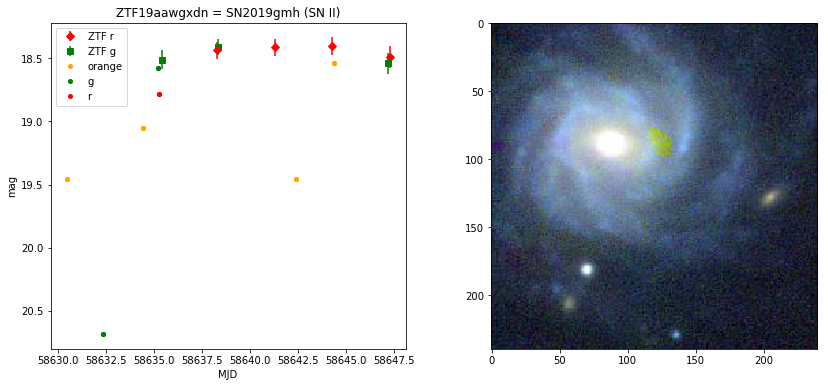

https://lasair.roe.ac.uk/object/ZTF19aanrrqu/


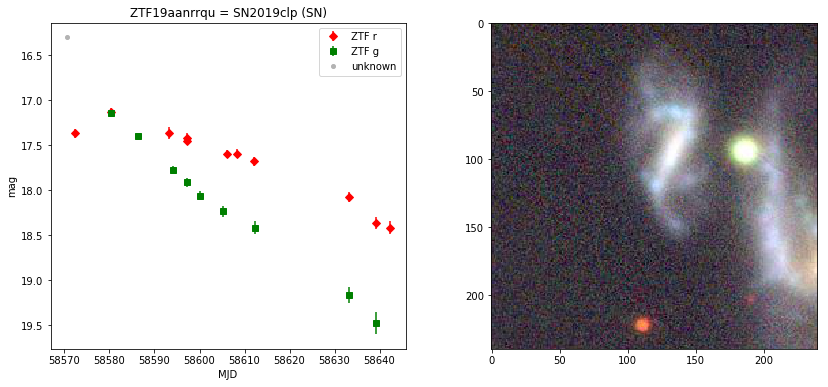

https://lasair.roe.ac.uk/object/ZTF19aanhhal/


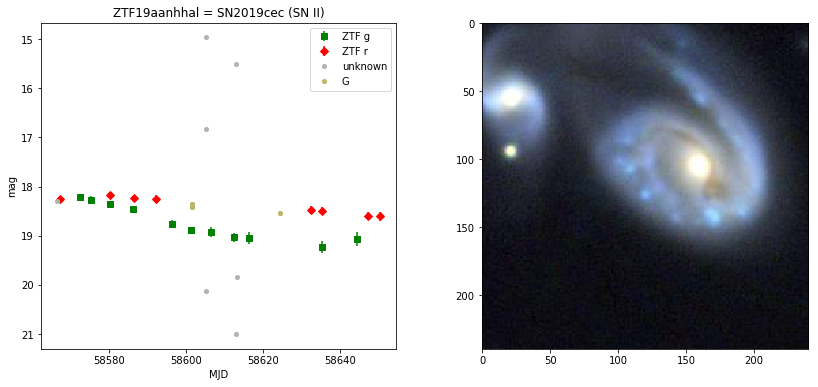

Done.


In [12]:
# Plot light curves

ztf_filts = {1:'g', 2:'r'}
ztf_markers = {1:'s', 2:'D'}

# if more filters from other surveys, add to colour pallet here:
other_filts = {'orange':'orange', 'cyan':'c', 'G':'darkkhaki', 'C':'pink',
               'w':'m', 'g':'g', 'r':'r', 'i':'goldenrod', 'z':'k'}

n = 1

for i in targetlist2:
    plt.figure(n,(14,6))    
    plt.subplot(121)
    for j in objectdict[i]['lc']:
        plt.errorbar(j['jd']-2400000.5,j['magpsf'],j['sigmapsf'],markersize=6,
                     fmt=ztf_markers[j['fid']],color=ztf_filts[j['fid']],label='ZTF '+ztf_filts[j['fid']])

    # include photometry from open catalog:
    if 'oac' in objectdict[i]:
        for k in objectdict[i]['oac']:
            try:
                plt.errorbar(k[0],k[1],k[2],fmt='o',markersize=4,color=other_filts[k[3]],label=k[3])
            except:
                try:
                    plt.errorbar(k[0],k[1],fmt='o',markersize=4,color=other_filts[k[3]],label=k[3])
                except:
                    plt.errorbar(k[0],k[1],fmt='o',markersize=4,color='0.7',label='unknown')

    # construct legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # format figure
    plt.xlabel('MJD')
    plt.ylabel('mag')
    plt.gca().invert_yaxis()
    figtitle = i
    if 'iau_name' in objectdict[i]:
        figtitle += ' = '+objectdict[i]['iau_name']
    if 'class' in objectdict[i]:
        figtitle += ' ('+objectdict[i]['class']+')'
    plt.title(figtitle)
    
    # show cutout
    if 'cutout' in objectdict[i]:
        if os.path.exists(objectdict[i]['cutout']):
            plt.subplot(122)
            file = objectdict[i]['cutout']
            try:
                img = mpimg.imread(file)
                plt.imshow(img)
            except:
                print("cannot find file ", file)

    print('https://lasair.roe.ac.uk/object/%s/' % i)
    plt.show()
    
    n += 1
    
print('Done.')